# 0 Overview
This notebook builds upon lecture 3's technical content on the steady state, showing how to compute *expectation functions*: functions giving the expected value, at each point in the state space, of some individual outcome at some horizon in the future.

Expectation functions (called "expectation vectors" in the [Sequence-Space Jacobian paper](http://mattrognlie.com/sequence_space_jacobian.pdf)) can be computed in a very efficient recursive way. They are useful for multiple purposes, as we'll describe in this notebook.

 - First, when describing the dynamics of individual agents in the aggregate steady state, expectation functions provide a way for us to obtain virtually any statistic of interest, with no Monte Carlo simulation needed.
 
 
 - Second, expectation functions allow us to project forward the aggregate effect of a perturbation to the distribution. This is useful in its own right, and will be a crucial ingredient in the "fake news algorithm" for sequence-space Jacobians, which we'll cover once we get to dynamics.
 

**Preliminaries.** Before we start, we'll import the basic Python libraries we'll be using, and also `sim_steady_state_fast`, the faster version of our steady-state module developed in `econ411_3_lecture3_supplement_speed.ipynb`.

In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import sim_steady_state_fast as sim

We'll also build a steady state that we can use later:

In [2]:
ss = sim.steady_state(**sim.example_calibration())

# 1 Expectation functions: the key idea
Suppose that we have some arbitrary function $x(e,a)$ of the household state.

We can ask the following question: if the state for an individual household is $(e_t,a_t)=(e,a)$ today, what (without any other information) do we expect $x(e_{t+j},a_{t+j})$ to be, assuming that the household follows the steady state policy rule?

Define this to be the $j$th **expectation function** of $(e,a)$:

$$
\mathcal{E}_j(e,a) \equiv \mathbb{E}[x(e_{t+j}, a_{t+j}) | (e_t, a_t)=(e,a)]
$$

The key idea here is that the *law of iterated expectations* makes computing $\mathcal{E}_j(e,a)$ into a simple recursion, with base case $\mathcal{E}_0(e,a)=x(e,a)$:

$$
\mathcal{E}_j(e,a) = \mathbb{E}[\mathcal{E}_{j-1}(e',a') | (e,a)] \tag{1}
$$

So long as we know how to calculate one-period-ahead expectations to evaluate the right side of (1), we can calculate expectation functions at any horizon!

# 2 Computation of expectation functions
**Taking expectations over asset choice.** Recall from lecture 3 that given $i(e,a)$ and $\pi(e,a)$, which described the lottery form of the steady-state policy, we update the beginning-of-period distribution $D_t(e,a)$ to an end-of-period distribution $D_t^{end}(e,a')$ using the following function:

In [3]:
@numba.njit
def forward_policy(D, a_i, a_pi):
    Dend = np.zeros_like(D)
    for e in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # send pi(e,a) of the mass to gridpoint i(e,a)
            Dend[e, a_i[e,a]] += a_pi[e,a]*D[e,a]
            
            # send 1-pi(e,a) of the mass to gridpoint i(e,a)+1
            Dend[e, a_i[e,a]+1] += (1-a_pi[e,a])*D[e,a]
            
    return Dend

The end-of-period distribution $D_t^{end}(e, a')$ is defined over a grid of assets $a'$ going into next period.

To iterate over expectations, we need to go in the *opposite direction*. We start with some end-of-period variable $X_t(e,a')$, defined over a grid of assets $a'$ going into next period, and obtain the beginning-of-period expectation $X_t(e,a) = \pi(e,a)*X_t^{end}(e,i(e,a)) + (1-\pi(e,a))*X_t^{end}(e,i(e,a)+1)$. Though we don't write it explicitly as a matrix, one can verify that this is actually the *transpose* of the linear mapping in `forward_policy`:

In [4]:
@numba.njit
def expectation_policy(Xend, a_i, a_pi):
    X = np.zeros_like(Xend)
    for e in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # expectation is pi(e,a)*Xend(e,i(e,a)) + (1-pi(e,a))*Xend(e,i(e,a)+1)
            X[e, a] = a_pi[e, a]*Xend[e, a_i[e, a]] + (1-a_pi[e, a])*Xend[e, a_i[e, a]+1]
            
    return X

**Taking expectations over the exogenous state.** Similarly, recall, from the previous lecture that to update the distribution with the exogenous shock, i.e. to update from $D_t^{end}(e,a')$ to $D_{t+1}(e',a')$, we multiplied by the *transpose* of the Markov matrix. We then combined this with the update defined above using the lottery:

In [5]:
def forward_iteration(D, Pi, a_i, a_pi):
    Dend = forward_policy(D, a_i, a_pi)    
    return Pi.T @ Dend

Similarly, here we need to obtain $X_t^{end}(e,a') = \mathbb{E}_t[X_{t+1}(e',a') | e]$ by taking expectations with respect to $e'$. To do this, we multiply by the Markov matrix itself (not its transpose!), just like we did when we needed to take expectations of the marginal value function in our backward iteration. Then, we combine this with the code we already wrote to obtain $X_t(e,a)$ from $X_t^{end}(e,a')$:

In [6]:
def expectation_iteration(X, Pi, a_i, a_pi):
    Xend = Pi @ X
    return expectation_policy(Xend, a_i, a_pi)

Note also that taking expectations goes in the opposite order (first take expectations with respect to $e'$, then $a'$) as updating the distribution, because it's going backward in time rather than forward.

**Why use matrix itself for taking expectations vs. transpose for updating the distribution?** Recall that in general, element $\pi_{ij}$ of some Markov matrix $\Pi$ is the probability of moving from state $i$ to state $j$. If we have some quantity $y_j$ that depends on the state $j$ tomorrow, then to take expectations conditional on state $i$ today, we need to take an average of $y_j$ weighted by the probabilities of transitioning from state $i$, i.e.

$$
\mathbb{E}[y_j|i] = \sum_j \pi_{ij}y_j
$$

which is the *definition* of matrix multiplication $\Pi y$. On the other hand, if we have some distribution $p_i$ of probability masses across states $i$ today, and we want to ask what the mass $P_j$ in state $j$ will be tomorrow, we need to sum up $p_i$ weighted by the probabilities of transitioning to state $j$, i.e.

$$
P_j = \sum_i \pi_{ji} p_i
$$

which is multiplication by the transpose, $\Pi' p$.

This is a very general principle: the linear map that updates the distribution, given a certain law of motion for agents, is always the transpose of the linear map that takes expectations. This is another way to remember why the order of steps is reversed in `forward_iteration` vs. `expectation_iteration`. The transpose of a product of matrices is the product of their transposes, in reverse order: $(AB)'=B'A'$.

**Iterating to obtain expectation functions at all horizons.** Now we can iteratively apply the `expectation_iteration` function, as in (1), to obtain expectations $\mathcal{E}_j(e,a)$ of some function $x(e,a)$ at all horizons $j$ up to some $T$.

We take in the array `X` of values of $x(e,a)$ on the state space, plus the lottery representation of the steady-state policy rule, `a_i` and `a_pi`, and the horizon `T`:

In [7]:
def expectation_functions(X, Pi, a_i, a_pi, T):
    # set up array of curlyEs and fill in first row with base case
    curlyE = np.empty((T, ) + X.shape)
    curlyE[0] = X
    
    # recursively apply law of iterated expectations
    for j in range(1, T):
        curlyE[j] = expectation_iteration(curlyE[j-1], Pi, a_i, a_pi)
        
    return curlyE

# 3 Examples: expectations of assets and consumption
Let's apply `expectation_functions` to obtain the expectation function for the asset state, up to horizon 100.

(Note that we are interested in the asset state, not the asset policy, so we use the asset grid as our outcome of interest, "broadcasting" it to be the same shape as the full state space, which is also the shape of the distribution, `ss['D'].shape`.)

In [8]:
A = np.broadcast_to(ss['a_grid'], ss['D'].shape)
Es_a = expectation_functions(A, ss['Pi'], ss['a_i'], ss['a_pi'], 100)

Now let's use the expectation functions to ask what the expected value of assets is in the future if we start today with zero assets, depending on the income state.

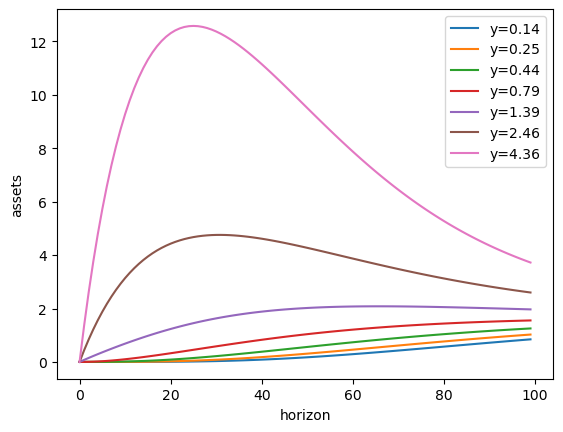

In [9]:
for e, ye in enumerate(ss['y']):
    plt.plot(Es_a[:, e, 0], label=f'y={ye:.2f}')
plt.legend()
plt.xlabel('horizon')
plt.ylabel('assets');

This is very intuitive: if we have a higher income state today, we will quickly accumulate assets, whereas if we have a lower income state today, we will probably be stuck at the constraint for quite a while. Eventually, however, all expectation functions converge to the mean asset level, because households' movement through the state space is ergodic - but this takes a while, and the convergence is not yet complete at date 100.

What if we instead assume that households start today at roughly the average level of assets?

In [10]:
i = np.searchsorted(ss['a_grid'], ss['A'])
i, ss['a_grid'][i], ss['A']

(147, 1.6716182286920747, 1.664507066193988)

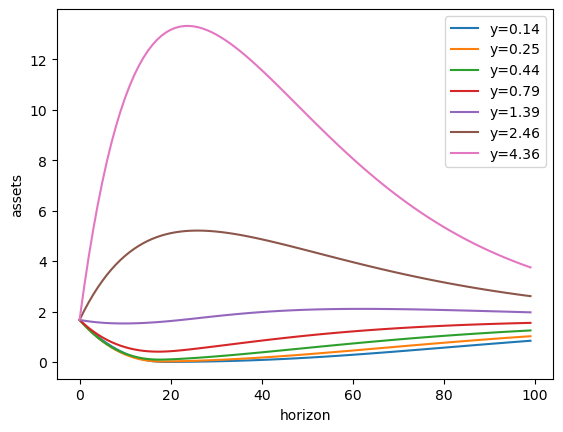

In [11]:
for e, ye in enumerate(ss['y']):
    plt.plot(Es_a[:, e, i], label=f'y={ye:.2f}')
plt.legend()
plt.xlabel('horizon')
plt.ylabel('assets');

This looks quite similar, but households with lower incomes will first deplete their assets (in expectation), before eventually converging back to the same average level.

We can, of course, also do this same calculation for consumption, looking at how expected consumption changes with horizon, assuming that we're at a roughly average level of assets today and various incomes.

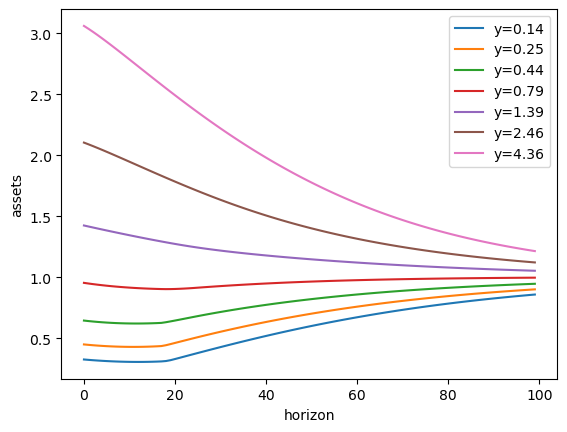

In [12]:
Es_c = expectation_functions(ss['c'], ss['Pi'], ss['a_i'], ss['a_pi'], 100)
for e, ye in enumerate(ss['y']):
    plt.plot(Es_c[:, e, i], label=f'y={ye:.2f}')
plt.legend()
plt.xlabel('horizon')
plt.ylabel('assets');

# 4 Obtaining statistics of interest
With a bit more effort, we can use expectation functions to calculate all kinds of interesting dynamic statistics about individual behavior in an aggregate steady state. For instance, what is the variance of the change in individual consumption between dates $t$ and $t+j$, looking across all individuals and realizations? Or, relatedly, how correlated are individual consumption at $t$ and $t+j$? If we run a regression of consumption at date $t+j$ on assets at date $t$, what will be the coefficient?

These are questions for which the vast majority of practitioners would assume we need to do Monte Carlo simulation—which can be costly, and only converges to the truth at a rate of $1/\sqrt{n}$, where $n$ is the number of simulation draws. Fortunately, it turns out that almost all questions of this kind can be answered efficiently with expectation functions.

**Example 1: variance of change in consumption and related statistics.**
The mean change in consumption across all households must be zero in an aggregate steady state. The variance of the change is therefore

$$
\begin{align}
\mathbb{E}[(c(e_{t+j},a_{t+j}) - c(e_t,a_t))^2]
&= \mathbb{E}[c(e_{t+j},a_{t+j})^2] + \mathbb{E}[c(e_t,a_t)^2] - 2\mathbb{E}[c(e_{t+j},a_{t+j})c(e_t,a_t)] \\
&= 2\mathbb{E}[c(e_t,a_t)^2] - 2\mathbb{E}[\mathbb{E}[c(e_{t+j},a_{t+j})|(e_t,a_t)]\cdot c(e_t,a_t)] \tag{2}
\end{align}
$$

There are several key steps here. First, we expand the square of a difference into three terms, and use linearity of expectations. Second, we replace $\mathbb{E}[c(e_{t+j},a_{t+j})^2]$ with $\mathbb{E}[c(e_t,a_t)^2]$, since the two are equal in an aggregate steady state (the distribution of individuals across states is the same in all periods). Third, use apply the law of iterated expectations to $\mathbb{E}[c(e_{t+j},a_{t+j})c(e_t,a_t)]$, replacing $c(e_{t+j},a_{t+j})$ with $\mathbb{E}[c(e_{t+j},a_{t+j})|(e_t,a_t)]$.

How can we calculate the terms in (2)? $\mathbb{E}[c(e_t,a_t)^2]$ is very easy, since it's just the cross-sectional average of the square of consumption, which we can calculate as `np.vdot(ss['D'], ss['c']**2)`.

Meanwhile, $\mathbb{E}[c(e_{t+j},a_{t+j})|(e_t,a_t)]$ is just the $j$th expectation functions of consumption that we've already calculated as `Es_c[j]`. For each $j$, we take the cross-sectional average of its product with $c(e_t,a_t)$ by writing `np.vdot(ss['D'], Es_c[j]*ss['c'])`. Combined, these calculations allow us to implement (2), and we'll store $\mathbb{E}[(c(e_{t+j},a_{t+j}) - c(e_t,a_t))^2]$ in an array `variance[j]`:

In [13]:
variance = np.empty(100)
for j in range(100):
    variance[j] = 2*(np.vdot(ss['D'], ss['c']**2) - np.vdot(ss['D'], Es_c[j]*ss['c']))

Let's plot this as a function of $j$:

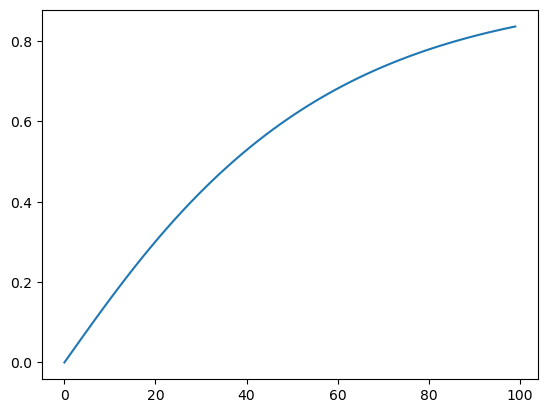

In [14]:
plt.plot(variance);

Interestingly, we see that initially the variance of changes in consumption increases almost linearly with the horizon. This suggests that in the very short run, consumption is close to (although in this case not exactly) a *random walk*, a la [Hall (1978)](https://www.journals.uchicago.edu/doi/abs/10.1086/260724). Eventually, however, the variance levels off—since this is a stationary model, it can't become infinite, and it asymptotes to twice the variance of consumption itself, which corresponds to zero covariance in consumption.

*Related statistics.* The autocovariance of consumption at dates $t$ and $t+j$ equals the second moment $\mathbb{E}[c(e_{t+j},a_{t+j})c(e_t,a_t)]$, which we discovered above that we could calculate as `np.vdot(ss['D'], Es_c[j]*ss['c'])`, minus $\mathbb{E}[c(e_t,a_t)]^2$, which is just aggregate assets squared. We therefore write:

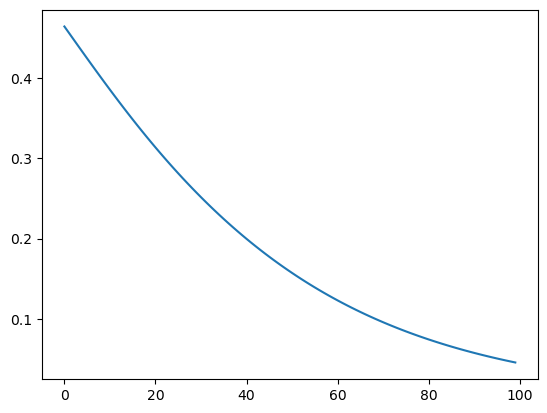

In [15]:
autocovariance = np.empty(100)
for j in range(100):
    autocovariance[j] = np.vdot(ss['D'], Es_c[j]*ss['c']) - ss['C']**2
plt.plot(autocovariance);

This is an exact mirror image of the variance of changes from above (indeed, their non-constant terms are just minus each other): it starts at the variance of consumption and declines to zero.

If we wanted to write this as an *autocorrelation*, we would divide by the variance of consumption, which is just the autocovariance at a horizon of zero. With this change in units, we see the drop in autocorrelation from one to zero as we increase the horizon:

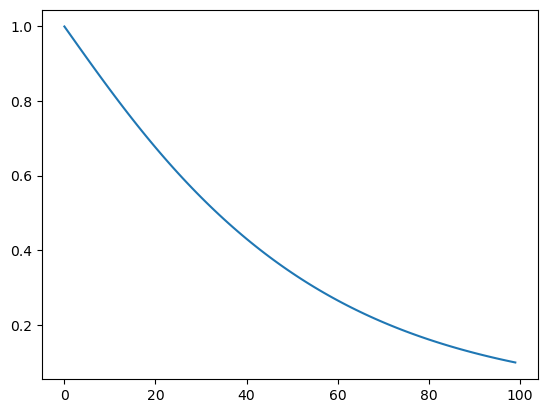

In [16]:
autocorrelation = autocovariance / autocovariance[0]
plt.plot(autocorrelation);

The $j$th autocorrelation also equals the regression coefficient of consumption at date $t+j$ on consumption at date $t$. (Note that correlation between $c_{t+j}$ and $c_t$ would in general be defined as $\text{Cov}(c_{t+j},c_t)/\sqrt{\text{Var}(c_{t+j})\text{Var}(c_t)}$ and this regression coefficient as $\text{Cov}(c_{t+j},c_t)/\text{Var}(c_t)$, but these are identical since we're in an aggregate steady state and $\text{Var}(c_{t+j}) = \text{Var}(c_t)$.)

**Example 2: regression of consumption on lagged assets.** The regression coefficient of consumption at $c_{t+j}$ on assets at date $j$ is $\text{Cov}(c_{t+j},a_t)/\text{Var}(a_t)$.

Defining $\tilde{c}(e,a)$ to be demeaned consumption, and similarly $\tilde{a}$ to be demeaned assets, these become just $\mathbb{E}[\tilde{c}_{t+j}\tilde{a}_t]/\mathbb{E}[\tilde{a}_t^2]$. The denominator is simple to calculate, and the numerator can be written

$$
\mathbb{E}[\tilde{c}(e_{t+j},a_{t+j})\tilde{a}_t]
= \mathbb{E}[\mathbb{E}[\tilde{c}(e_{t+j},a_{t+j})|(e_t,a_t)]\tilde{a}_t]
$$

$\mathbb{E}[\tilde{c}(e_{t+j},a_{t+j})|(e_t,a_t)]$ is just the expectation vector for $c$, demeaned, and then we have to multiply it by $\tilde{a}$ and take the cross-sectional average.

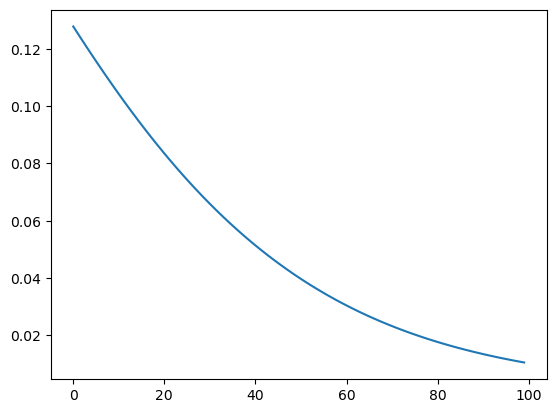

In [17]:
a_tilde = ss['a'] - ss['A']
var_a = np.vdot(ss['D'], a_tilde**2) # denominator
 
coeffs = np.empty(100)
for j in range(100):
    coeffs[j] = np.vdot(ss['D'], (Es_c[j] - ss['C'])*a_tilde) / var_a

plt.plot(coeffs);

We see that the contemporaneous regression coefficient of consumption on assets is a bit above 12%, and that this only slowly decays to zero when we look at the coefficient of consumption on lagged assets - although, of course, that could be because assets (or income, which is correlated) themselves change little over time. This is, of course, not a causal estimate!

**Verifying correctness using an alternative: Monte Carlo.** Let's verify one of these calculations using Monte Carlo simulation of individual households, which would be the more traditional (and inferior!) approach. First, write code that takes in a state $(e,a)$ and updates to the next period's state $(e',a')$.

In [18]:
Pi_cumul = ss['Pi'].cumsum(axis=1)
a_grid = ss['a_grid']
a_i, a_pi = ss['a_i'], ss['a_pi']
S = len(Pi_cumul)

@numba.njit
def update(e, a):
    pi = a_pi[e, a]
    if np.random.rand() < pi:
        ap = a_i[e, a]
    else:
        ap = a_i[e, a] + 1 
        
    # choose from transition probabilities Pi[e, :] by picking
    # random number between 0 and 1, then by iterating until
    # we exceed cumulative sum of Pi[e, :]. could do binary search
    # or other method for greater efficiency with many states
    r = np.random.rand()
    for sp in range(S):
        if Pi_cumul[e, sp] > r:
            break
    return sp, ap

Let's test this simple simulation code to see that it gives the correct average level of assets if we do enough draws.

In [19]:
@numba.njit
def average_assets(Ndraw):
    e, a = 0, 0 # arbitrarily start at bottom, alternatively could pick randomly
    total_a = 0
    for _ in range(Ndraw):
        total_a += a_grid[a]
        e, a = update(e, a)
    return total_a / Ndraw

We see that it indeed does cluster around the right mean, but even a simulation of length 100,000 can be shockingly inaccurate (because autocorrelation in assets means that there aren't nearly so many independent draws), which is a reminder that at least naive Monte Carlo is problematic here. 

In [20]:
print(f'Actual average assets: {ss["A"].round(3)}')
print(f'Five simulations {np.array([average_assets(100_000) for _ in range(5)]).round(3)}') 

Actual average assets: 1.665
Five simulations [1.622 1.803 1.647 1.671 1.56 ]


Now let's write similar code to examine the variance of 2-period changes in consumption, and see if our earlier finding was right.

In [21]:
cpol = ss['c']

@numba.njit
def variance_consumption_change(Ndraw):
    total_squared = 0
    
    # start with history of two, arbirarily start at bottom
    clag = cpol[0, 0]
    e, a = update(0, 0)
    c = cpol[e, a]
    
    for _ in range(Ndraw):
        enew, anew = update(e, a)
        cnew = cpol[enew, anew]
        total_squared += (cnew - clag)**2
        
        e, a = enew, anew
        clag = c
        c = cnew
    
    return total_squared / Ndraw

In [22]:
print(f'Actual variance of two-period changes: {variance[2]:.4f}')
print(f'Five simulations {np.array([variance_consumption_change(100_000) for _ in range(5)]).round(4)}') 

Actual variance of two-period changes: 0.0320
Five simulations [0.0318 0.0327 0.0313 0.0332 0.0323]


# 5 Projecting forward the effects of distributional shocks
Suppose that I perturb the steady-state distribution in some way at the beginning of date 0, and ask—if everyone follows their steady-state policies—how this will impact consumption for the next 100 periods.

The straightforward way to do this calculation would be to take the modified distribution and iterate forward on it to calculate consumption:

In [23]:
def consumption_path(D):
    C = np.empty(100)
    for t in range(100):
        C[t] = np.vdot(D, ss['c'])
        D = sim.forward_iteration(D, ss['Pi'], ss['a_i'], ss['a_pi'])
    return C

But expectation functions offer an alternative approach. The key insight is the following. Since we have a perfect foresight path from date 0 onward, if I take the expectation at date 0 of consumption at date $t$, averaged across the distribution at date 0, *I will get the actual average level of consumption at each date $t$*.

Let's implement this here.

In [24]:
def consumption_path_exp(D):
    C = np.empty(100)
    for t in range(100):
        # to get consumption at date t, just aggregate
        # horizon-t expectation function across the distribution
        C[t] = np.vdot(D, Es_c[t])
    return C

Let's pick an arbtrary perturbation to the distribution - just to be goofy, let's flip the income dimension, so that we assign the highest incomes to the lowest, and vice versa.

In [25]:
Dmod = ss['D'][::-1] # flip leading dimension

And now let's check that the two consumption path functions give essentially identical answers:

In [26]:
np.max(np.abs(consumption_path(Dmod) - consumption_path_exp(Dmod)))

3.1086244689504383e-15

Great! How fast are the two functions?

In [27]:
%timeit consumption_path(Dmod)
%timeit consumption_path_exp(Dmod)

1.07 ms ± 7.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
257 µs ± 306 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


The approach using expectation functions is much faster, because we don't need to iterate forward on the actual distribution (and the speed gap would be much larger if we didn't have very efficient code for iterating on the distribution).

Of course, this might seem a little unfair, since in order to implement `consumption_path_exp`, we needed to calculate the expectation function in the first place, which requires an amount of work comparable to `consumption_path`. That's true—but the beauty is that we can calculate the expectation function once, and then reuse it over and over, if needed, for many different perturbations to the distribution. This trick will turn out to be essential to the "fake news algorithm".

A nerdy but useful note: it turns out that `consumption_path_exp` can be made even faster. It consists of 100 dot products of two $n_e\times n_a$ arrays, one varying across the 100 dot products and the other not. This is equivalent to just multiplying one $100\times (n_e\cdot n_a)$ matrix times a $n_e\cdot n_a$ vector, which we can implement in the following one-liner:

In [28]:
def consumption_path_exp_fast(D):
    return Es_c.reshape(100, -1) @ D.ravel()

Verify that it gives the same answer and test its speed, which has now improved by an additional factor of six:

In [29]:
np.max(np.abs(consumption_path(Dmod) - consumption_path_exp_fast(Dmod)))

1.7763568394002505e-15

In [30]:
%timeit consumption_path_exp_fast(Dmod)

38.9 µs ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
